# WiDS 2025
### Sex Patterns in ADHD

### Import

In [22]:
import pandas as pd
import numpy as np
import math


from sklearn.compose import ColumnTransformer
from sklearn.linear_model import MultiTaskElasticNetCV, LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline, Pipeline


import seaborn as sns
import matplotlib.pyplot as plt

# Multi-output
from sklearn.multioutput import MultiOutputClassifier

# Multi-task
from sklearn.linear_model import MultiTaskElasticNetCV


In [23]:
source = "TRAIN"
connectome_train = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_train = pd.read_csv(f"{source}/{source}_CATEGORICAL_METADATA.csv")
quan_train = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")
label = pd.read_csv(f"{source}/TRAINING_SOLUTIONS.csv")

In [24]:
source = "TEST"
connectome_test = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_test = pd.read_csv(f"{source}/{source}_CATEGORICAL.csv")
quan_test = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")

In [25]:
train = connectome_train.merge(quan_train, on= 'participant_id').merge(cat_train, on= 'participant_id')
train.head(5)

test = connectome_train.merge(quan_test, on= 'participant_id').merge(cat_test, on= 'participant_id')


In [26]:
train.set_index('participant_id',inplace=True)
test.set_index('participant_id',inplace=True)
label.set_index('participant_id',inplace=True)

In [27]:
# Explore Null data
pd.DataFrame(train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count
MRI_Track_Age_at_Scan,360
PreInt_Demos_Fam_Child_Ethnicity,11


In [28]:
# Filter out the row index of 
'''null_index = train[train.isnull().any(axis=1)].index

train = train[~train.index.isin(null_index)]
label = label[~label.index.isin(null_index)]'''

'null_index = train[train.isnull().any(axis=1)].index\n\ntrain = train[~train.index.isin(null_index)]\nlabel = label[~label.index.isin(null_index)]'

### EDA

Cleaning checklist:

Null: ?. Null Var importance? 

Each Var Normal Range -> Detect Anomalies -> remove or something else

Data Type: Check categorical to have uniformed labels. check normal range if coded. Norminal type -> one-hot-code, ordinal -> label encode ()



### EDA - Quantitative variables

In [31]:
# Merge the dataframes (quan_train and label) on 'participant_id'
merged_df = pd.merge(quan_train, label, on='participant_id')
merged_df

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,...,1,5,0,5,1,0,10,NaN,1,1
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,...,6,8,7,8,10,4,5,NaN,1,0
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,...,2,8,5,7,6,4,9,8.239904,1,0
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,...,4,16,9,10,8,4,6,NaN,1,1
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,...,4,11,4,10,7,3,9,8.940679,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,87.80,14,5,14,39,20,15,21,1,...,2,7,3,6,2,0,9,10.697923,0,0
1209,groSbUfkQngM,77.80,14,3,10,32,20,11,23,6,...,3,11,9,5,7,4,7,13.964750,0,1
1210,zmxGvIrOD0bt,16.68,14,3,16,28,15,19,27,3,...,1,3,0,0,1,0,10,NaN,0,1
1211,rOmWFuJCud5G,53.40,14,3,14,34,18,23,23,4,...,0,9,3,5,0,0,9,12.089094,0,0


array([[<Axes: title={'center': 'EHQ_EHQ_Total'}>,
        <Axes: title={'center': 'ColorVision_CV_Score'}>,
        <Axes: title={'center': 'APQ_P_APQ_P_CP'}>,
        <Axes: title={'center': 'APQ_P_APQ_P_ID'}>],
       [<Axes: title={'center': 'APQ_P_APQ_P_INV'}>,
        <Axes: title={'center': 'APQ_P_APQ_P_OPD'}>,
        <Axes: title={'center': 'APQ_P_APQ_P_PM'}>,
        <Axes: title={'center': 'APQ_P_APQ_P_PP'}>],
       [<Axes: title={'center': 'SDQ_SDQ_Conduct_Problems'}>,
        <Axes: title={'center': 'SDQ_SDQ_Difficulties_Total'}>,
        <Axes: title={'center': 'SDQ_SDQ_Emotional_Problems'}>,
        <Axes: title={'center': 'SDQ_SDQ_Externalizing'}>],
       [<Axes: title={'center': 'SDQ_SDQ_Generating_Impact'}>,
        <Axes: title={'center': 'SDQ_SDQ_Hyperactivity'}>,
        <Axes: title={'center': 'SDQ_SDQ_Internalizing'}>,
        <Axes: title={'center': 'SDQ_SDQ_Peer_Problems'}>],
       [<Axes: title={'center': 'SDQ_SDQ_Prosocial'}>,
        <Axes: title={'center

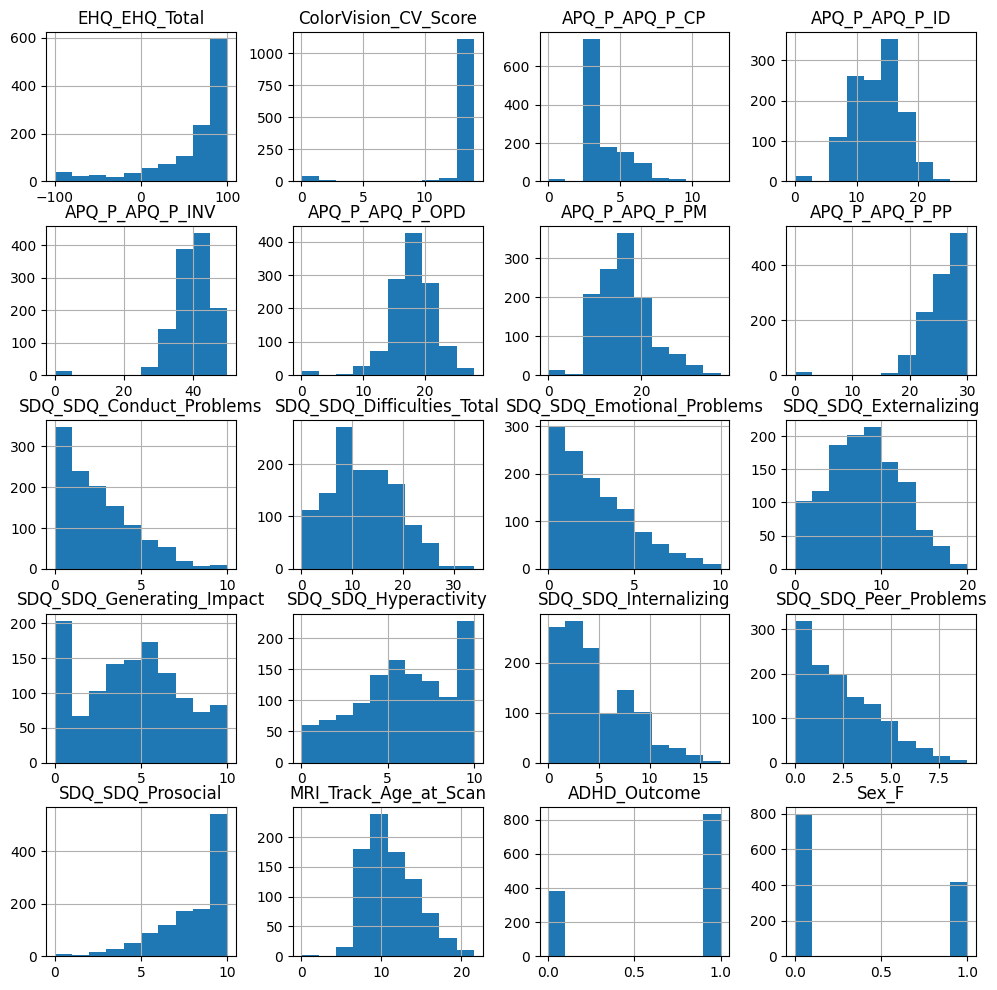

In [32]:
# Plot histograms for all variables 
merged_df.hist(figsize=(12, 12))

#### Boxplots - Gender vs Quantitative variables

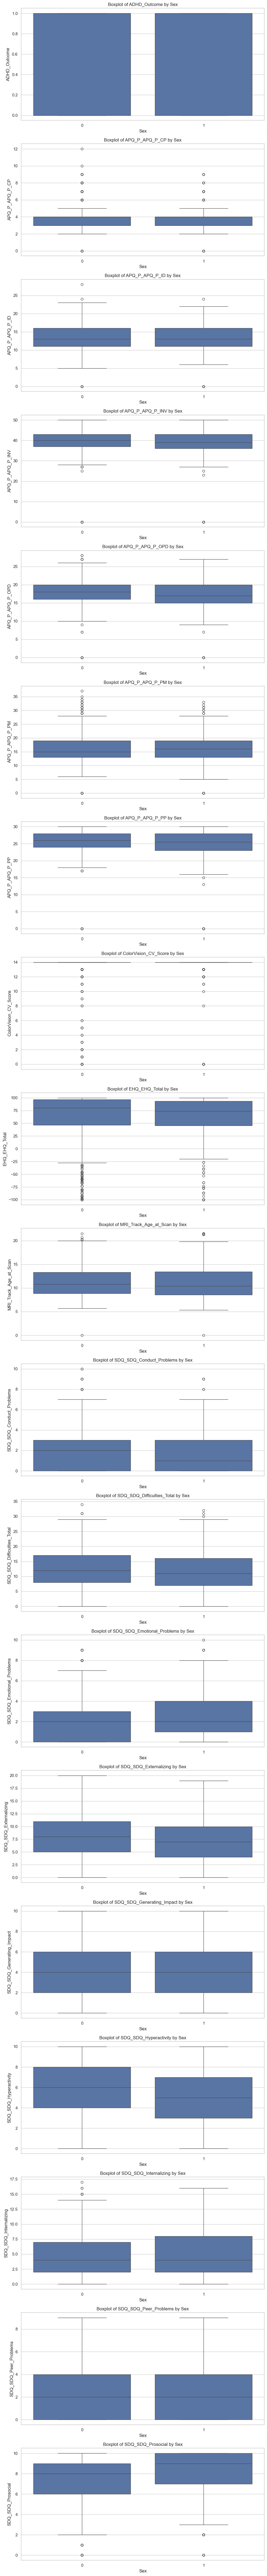

In [ ]:
# Set the style of the visualization
sns.set(style="whitegrid")

# List of quantitative variables
quantitative_vars = merged_df.columns.difference(['participant_id', 'Sex_F'])

# Create a figure with subplots for each quantitative variable
fig, axes = plt.subplots(len(quantitative_vars), 1, figsize=(10, len(quantitative_vars) * 5))

# Loop through each variable and create a boxplot
for i, var in enumerate(quantitative_vars):
    sns.boxplot(data=merged_df, x='Sex_F', y=var, ax=axes[i])
    axes[i].set_title(f'Boxplot of {var} by Sex_F')
    axes[i].set_xlabel('Sex')
    axes[i].set_ylabel(var)

# Adjust layout
plt.tight_layout()
plt.show()

#### Boxplots - ADHD vs Quantitative variables

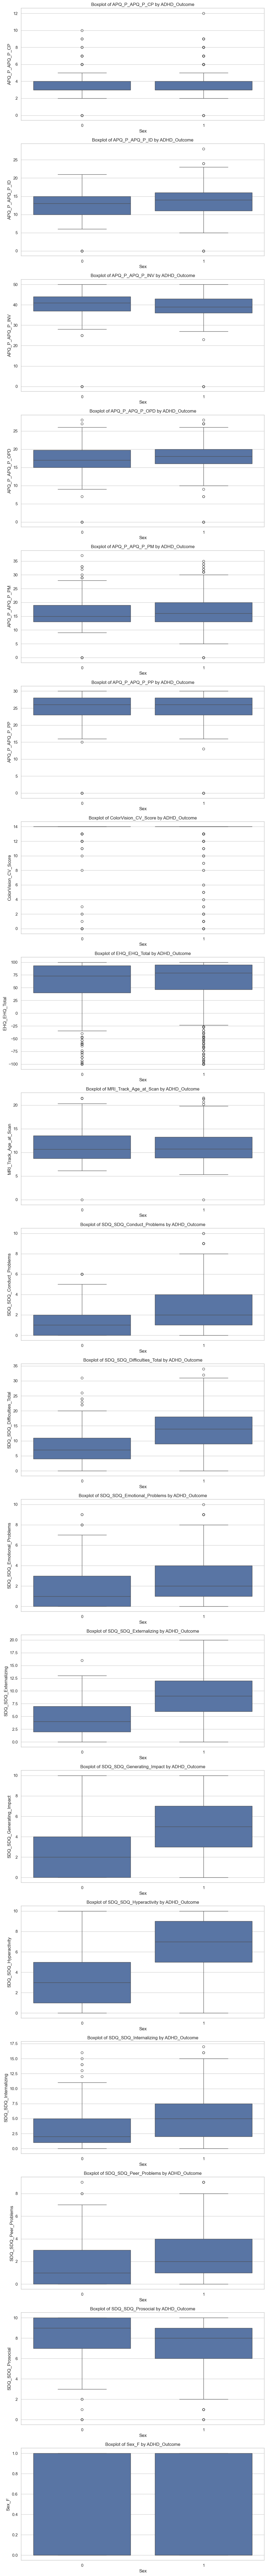

In [38]:
# Set the style of the visualization
sns.set(style="whitegrid")

# List of quantitative variables
quantitative_vars = merged_df.columns.difference(['participant_id', 'ADHD_Outcome'])  

# Create a figure with subplots for each quantitative variable
fig, axes = plt.subplots(len(quantitative_vars), 1, figsize=(10, len(quantitative_vars) * 5))

# Loop through each variable and create a boxplot
for i, var in enumerate(quantitative_vars):
    sns.boxplot(data=merged_df, x='ADHD_Outcome', y=var, ax=axes[i])
    axes[i].set_title(f'Boxplot of {var} by ADHD_Outcome')
    axes[i].set_xlabel('Sex')
    axes[i].set_ylabel(var)

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
label.ADHD_Outcome.value_counts()
# 383 neg, 831 pos

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

In [9]:
label.Sex_F.value_counts()
# 797 M, 416 F

Sex_F
0    797
1    416
Name: count, dtype: int64

In [10]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'], normalize='all')

Sex_F,0,1
ADHD_Outcome,,
0,0.178071,0.136851
1,0.478978,0.206101


In [11]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'])

Sex_F,0,1
ADHD_Outcome,,
0,216,166
1,581,250


In [12]:
connectome_train.set_index('participant_id', inplace= True)

In [13]:
df = connectome_train.iloc[:,:5]

In [14]:
df

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn
participant_id,,,,,
70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221
WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899
4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085
obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431
s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139
...,...,...,...,...,...
kTurROKp5YHQ,0.022932,0.024830,-0.006514,0.021070,0.093365
FCRyMz9O6yCq,0.047078,0.135955,0.144366,0.054938,0.065760
vm2P1hmAY1hl,0.094541,0.145280,0.061964,0.030562,0.078278


# Model Train
Baseline model: Multi-output pipeline for same model.
- Logistic Reg with L1 norm for sparsity and inference enhancement
- NN with 2 output nodes with binary classifier activiation function (Sigmoid)

Performance: Multi-task models with shared features for correlated tasks.
- Multitask Lasso or multitask Elastic Net

### Train - test split


In [15]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state=527)


In [16]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(849, 19927)
(364, 19927)
(849, 2)
(364, 2)


In [17]:
pd.DataFrame(x_train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count
MRI_Track_Age_at_Scan,248
PreInt_Demos_Fam_Child_Ethnicity,5


In [18]:
y_train.dtypes

ADHD_Outcome    int64
Sex_F           int64
dtype: object

### Visual call-out Functions

In [19]:
def model_result(y_test, y_pred, model_name):
    """
    Compute and display important performance metrics for a classification model, 
    including F1-score, sensitivity, specificity, and a confusion matrix heatmap.

    Parameters:
    -----------
    y_test : array-like or Series (Truth)
    y_pred : array-like or Series (Model prediction)
    model_name : str

    Outputs:
    --------
    - Prints the F1-score, sensitivity (recall), and specificity.
    - Displays a heatmap of the confusion matrix for easier interpretation.

    Usage:
    ------
    1. Pass `y_test` and `y_pred` as arrays (or pandas Series).
    2. Provide a descriptive `model_name`(model and dataset used) to label the confusion matrix plot.
    """
    classes = ['Negative', 'positive']
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Compute confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate sensitivity and specificity
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    # Print results
    print('Accuracy: ', accuracy)
    print(f"Sensitivity (Recall/True Positive Rate): {sens:.2f}")
    print(f"Specificity (True Negative Rate): {spec:.2f}")
    print('f1: ', f1_score(y_test, y_pred))

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix of {model_name}")
    plt.show()

### Preprocessing
A pipeline that transform categorical into one-hot code, and quant data into a standard scaler

In [20]:
# Remove 2 features with null

categorical_features = list(cat_train.drop(['participant_id', 'PreInt_Demos_Fam_Child_Ethnicity'], axis= 1).columns)
numeric_features = train.drop(cat_train.drop(['participant_id', 'PreInt_Demos_Fam_Child_Ethnicity'], axis = 1).columns, axis = 1).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

### Multi-output
Perform the same model for both tasks

In [21]:
# Multi-output model for log classifier with 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(penalty='l1', solver='liblinear')))
])

pipeline.fit(x_train, y_train)

model = pipeline.named_steps['classifier']

y_pred = pipeline.predict(x_test)
f1 = f1_score(y_test,y_pred, average = 'micro')
print(f'f1 score of Multi-output Log Regression with L1 : {f1:.2f}')

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Looking closer into each classes metrics

Accuracy:  0.6071428571428571
Sensitivity (Recall/True Positive Rate): 0.81
Specificity (True Negative Rate): 0.17
f1:  0.7376146788990826


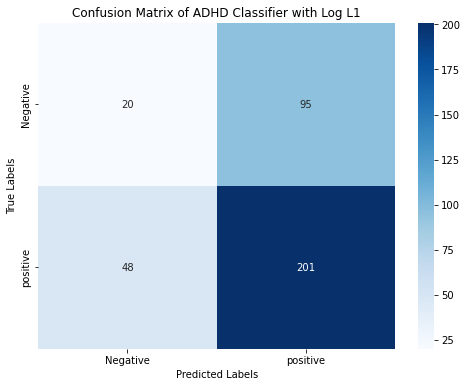

In [59]:
model_result(y_test['ADHD_Outcome'], y_pred[:,0], "ADHD Classifier with Log L1")

Accuracy:  0.5879120879120879
Sensitivity (Recall/True Positive Rate): 0.22
Specificity (True Negative Rate): 0.79
f1:  0.27884615384615385


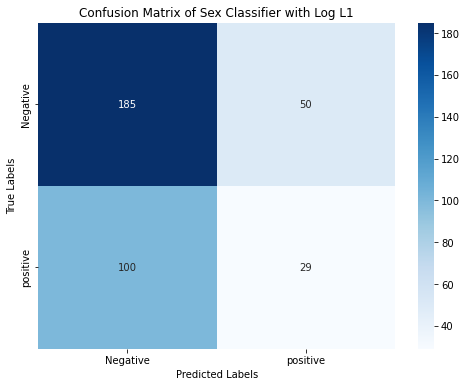

In [60]:
model_result(y_test['Sex_F'], y_pred[:,1], "Sex Classifier with Log L1")

Log while produce about less then 0.6 acc for both classes which is a bit over random guess, it produce extremely low f1 score for Gender.

### Multi-task Models
